<a href="https://colab.research.google.com/github/Oleksij-gh/infotech-task/blob/main/infotech_test_task_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Libs

In [1]:
import copy
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import f1_score as f1

# 2. Loading Data

In [19]:
!gdown 1FYaj-YQn7WADkCflz8-4Q89G9Aj8XxOi

Downloading...
From: https://drive.google.com/uc?id=1FYaj-YQn7WADkCflz8-4Q89G9Aj8XxOi
To: /content/schedule_dataset.xlsx
100% 8.31M/8.31M [00:00<00:00, 107MB/s]


In [20]:
df = pd.read_excel('/content/schedule_dataset.xlsx')

In [21]:
df.head()

,Дата рейса,Рейс,А/П отправл,А/П прибыт,Номер ВС,Время отправления по расписанию,Время отправления фактическое,Время прибытия по расписанию,Время прибытия фактическое
0,2018-03-01,1,MOW,ARH,1,2018-03-01 00:05:00,2018-02-28 23:48:00,2018-03-01 02:00:00,2018-03-01 01:48:00
1,2018-03-01,2,MOW,EGO,2,2018-03-01 00:05:00,2018-03-01 00:00:00,2018-03-01 01:30:00,2018-03-01 01:55:00
2,2018-03-01,3,MOW,AKX,3,2018-03-01 00:15:00,2018-03-01 00:14:00,2018-03-01 02:40:00,2018-03-01 02:32:00
3,2018-03-01,4,LED,MOW,4,2018-03-01 00:20:00,2018-03-01 00:11:00,2018-03-01 01:35:00,2018-03-01 01:39:00
4,2018-03-01,5,MOW,KRR,5,2018-03-01 00:25:00,2018-03-01 00:21:00,2018-03-01 02:40:00,2018-03-01 02:41:00


# 3. Data preprocessing

In [22]:
def preprocess(df):

  # Переименуем столбцы
  df  = df.rename(columns={'Дата рейса': 'flight_date',
                   'Рейс': 'flight',
                   'А/П отправл': 'airport_out',
                   'А/П прибыт': 'airport_in',
                   'Номер ВС': 'air_number',
                   'Время отправления по расписанию': 'scheduled_time_out',
                   'Время отправления фактическое': 'actual_time_out',
                   'Время прибытия по расписанию': 'scheduled_time_in',
                   'Время прибытия фактическое': 'actual_time_in'})

  # Извлечем день и месяц полёта в отдельные признаки и удаляем исходный столбец
  df['flight_month'] = df.apply(lambda x: x['flight_date'].month, axis=1)
  df['flight_day'] = df.apply(lambda x: x['flight_date'].day, axis=1)
  df['day_of_week'] = df.apply(lambda x: x['flight_date'].day_name(), axis=1)
  df = df.drop('flight_date', axis=1)

  # Извлечем время взлёта\посадки в отдельный признак
  df['time_part_out'] = df.apply(lambda x: (x['scheduled_time_out'].hour) // 3, axis=1)
  df['time_part_in'] = df.apply(lambda x: (x['scheduled_time_in'].hour) // 3, axis=1)

  # Преобразование номера ВС, времени взлёта\посадки к типу object,
  # т.к. это категориальные признаки и в дальнейшем будут преобразованы с помощью endcoder
  df['air_number'] = df['air_number'].astype(object)
  df['time_part_out'] = df['time_part_out'].astype(object)
  df['time_part_in'] = df['time_part_in'].astype(object)

  return df


In [23]:
def get_df_target(df, type_target, delay=True):

  def get_delay_class(scheduled_time, actual_time, delay=True):
    sec = (actual_time - scheduled_time ).total_seconds()
    if not delay:
      sec = -sec

    if sec < 0:
      return np.nan
    elif sec == 0:
      return 0
    else:
      return 1

  df['target'] = df.apply(lambda x: get_delay_class(x['scheduled_time_' + type_target], x['actual_time_' + type_target], delay), axis=1)

  # отбрасываем лишнии для обучения данные и переназначаем индексы
  df = df.dropna()
  df = df.reset_index()
  del df['index']

  # Удаляем лишние столбцы
  df = df.drop(['actual_time_out', 'actual_time_in'], axis=1)

  return df


# Формирование датасета

## One-hot-encoder

In [6]:
from sklearn.preprocessing import OneHotEncoder

In [24]:
def encode(df):
  categorical_columns = ['airport_out', 'airport_in', 'air_number', 'day_of_week', 'time_part_out', 'time_part_in']
  categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
  encoder = OneHotEncoder(sparse_output=False)
  ohe = encoder.fit_transform(df[categorical_columns])
  ohe_df = pd.DataFrame(ohe, columns=encoder.get_feature_names_out(categorical_columns))
  df = pd.concat([df, ohe_df], axis=1)
  df = df.drop(categorical_columns, axis=1)
  return df

## Train Test Val split

In [25]:
def split_data(X, y, seed=42):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed)

  return X_train, y_train, X_val, y_val, X_test, y_test

# 4. Models

## sklearn models

### Fit

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


def train(X_train, y_train):

  models = {}

  # Logistic Regression
  models['Logistic Regression'] = LogisticRegression()

  # Support Vector Machines
  models['Support Vector Machines'] = LinearSVC()

  # Decision Trees
  models['Decision Trees'] = DecisionTreeClassifier()

  # Random Forest
  models['Random Forest'] = RandomForestClassifier()

  # Naive Bayes
  models['Naive Bayes'] = GaussianNB()

  # K-Nearest Neighbors
  models['K-Nearest Neighbor'] = KNeighborsClassifier()

  for key in models.keys():

      # Fit the classifier
      models[key].fit(X_train, y_train)
  return models


### Evaluate

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


def evaluate(models, X_val, y_val):
  accuracy, precision, recall, f1 = {}, {}, {}, {}
  tn, fp, fn, tp = {}, {}, {}, {}
  for key in models.keys():

      # Make predictions
      predictions = models[key].predict(X_val)

      # Calculate metrics
      accuracy[key] = accuracy_score(predictions, y_val)
      precision[key] = precision_score(predictions, y_val)
      recall[key] = recall_score(predictions, y_val)
      f1[key] = f1_score(predictions, y_val)

      #TN, FP, FN, TP = confusion_matrix(y_val, predictions).ravel()
      #tn[key] = TN
      #fp[key] = FP
      #fn[key] = FN
      #tp[key] = TP
  df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
  df_model['Accuracy'] = accuracy.values()
  df_model['Precision'] = precision.values()
  df_model['Recall'] = recall.values()
  df_model['F1'] = f1.values()

  #df_model['TN'] = tn.values()
  #df_model['FP'] = fp.values()
  #df_model['FN'] = fn.values()
  #df_model['TP'] = tp.values()

  return df_model


### Plot metrics

In [11]:
def plot_metrics(df_model, models):
  ax = df_model.plot.barh()
  ax.legend(
      ncol=len(models.keys()),
      bbox_to_anchor=(0, 1),
      loc='lower left',
      prop={'size': 14}
  )
  plt.tight_layout()


# Initialize

In [26]:
df = preprocess(df)
df = encode(df)

In [27]:
df.head()

,flight,scheduled_time_out,actual_time_out,scheduled_time_in,actual_time_in,flight_month,flight_day,airport_out_AAQ,airport_out_ABA,airport_out_AER,...,time_part_out_6,time_part_out_7,time_part_in_0,time_part_in_1,time_part_in_2,time_part_in_3,time_part_in_4,time_part_in_5,time_part_in_6,time_part_in_7
0,1,2018-03-01 00:05:00,2018-02-28 23:48:00,2018-03-01 02:00:00,2018-03-01 01:48:00,3,1,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2018-03-01 00:05:00,2018-03-01 00:00:00,2018-03-01 01:30:00,2018-03-01 01:55:00,3,1,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2018-03-01 00:15:00,2018-03-01 00:14:00,2018-03-01 02:40:00,2018-03-01 02:32:00,3,1,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2018-03-01 00:20:00,2018-03-01 00:11:00,2018-03-01 01:35:00,2018-03-01 01:39:00,3,1,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2018-03-01 00:25:00,2018-03-01 00:21:00,2018-03-01 02:40:00,2018-03-01 02:41:00,3,1,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
df_delay_in = get_df_target(df, 'in', True)
df_delay_out = get_df_target(df, 'out', True)
df_hurry_in = get_df_target(df, 'in', False)
df_hurry_out = get_df_target(df, 'out', False)

In [30]:
df_delay_in = df_delay_in.drop(['scheduled_time_out', 'scheduled_time_in'], axis=1)
df_delay_out = df_delay_out.drop(['scheduled_time_out', 'scheduled_time_in'], axis=1)
df_hurry_in = df_hurry_in.drop(['scheduled_time_out', 'scheduled_time_in'], axis=1)
df_hurry_out = df_hurry_out.drop(['scheduled_time_out', 'scheduled_time_in'], axis=1)

In [38]:
models_rf = {}

## df_delay_in

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Accuracy,Precision,Recall,F1
Logistic Regression,0.923071,1.000000,0.923071,0.959997
Support Vector Machines,0.920344,0.996509,0.923281,0.958498
Decision Trees,0.861841,0.927043,0.923571,0.925304
Random Forest,0.922162,0.998836,0.923141,0.959498
Naive Bayes,0.391588,0.365052,0.937902,0.525549
K-Nearest Neighbor,0.919270,0.995166,0.923339,0.957908


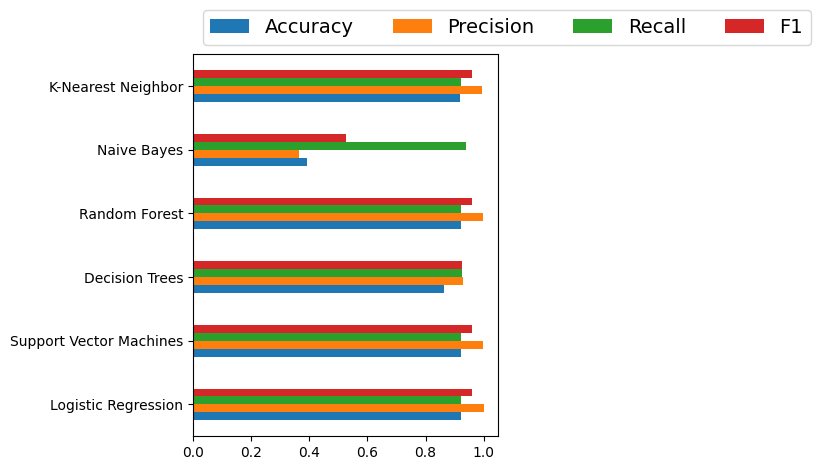

In [39]:
#data = encode(df_delay_in)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_delay_in.drop('target', axis=1), df_delay_in['target'])
models = train(X_train, y_train)
models_rf['df_delay_in'] = models['Random Forest']
df_val = evaluate(models, X_val, y_val)
plot_metrics(df_val, models)
df_val

## df_delay_out

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_delay_out.drop('target', axis=1), df_delay_out['target'])
models = train(X_train, y_train)
models_rf['df_delay_out'] = models['Random Forest']
df_val = evaluate(models, X_val, y_val)
plot_metrics(df_val, models)
df_val

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## df_hurry_in

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_hurry_in.drop('target', axis=1), df_hurry_in['target'])
models = train(X_train, y_train)
models_rf['df_hurry_in'] = models['Random Forest']
df_val = evaluate(models, X_val, y_val)
plot_metrics(df_val, models)
df_val

## df_hurry_out

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_hurry_out.drop('target', axis=1), df_hurry_out['target'])
models = train(X_train, y_train)
models_rf['df_hurry_out'] = models['Random Forest']
df_val = evaluate(models, X_val, y_val)
plot_metrics(df_val, models)
df_val

# Test